In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install gym_cartpole_swingup

     |████████████████████████████████| 1.6MB 6.0MB/s 
  Created wheel for gym: filename=gym-0.18.0-cp37-none-any.whl size=1656451 sha256=7d6afbfb83515a90c6708f997c6ca24ef71183435767b0a0e208b05f00f49733
  Stored in directory: /root/.cache/pip/wheels/be/85/3b/480b828a4a697b37392740a040b8989f729d952b4e441a1877
Successfully built gym
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [ ]:
pip install stable_baselines3

     |████████████████████████████████| 153kB 5.5MB/s 


In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [230]:
import gym
import gym_cartpole_swingup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import seaborn as sb
import math
from IPython.display import clear_output

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from pyvirtualdisplay import Display
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions

In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common import results_plotter

In [ ]:
lbr = "\n"

Helper Functions

In [219]:
pathprefix = "/content/"
googledrive_dir = "/content/drive/MyDrive/ARL/"
os.makedirs(googledrive_dir, exist_ok=True)
log_dir1 = googledrive_dir + "logs1"
log_dir2 = googledrive_dir + "logs2"
log_dir = googledrive_dir + "logs"
os.makedirs(log_dir1, exist_ok=True)
os.makedirs(log_dir2, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

sample_dir = googledrive_dir + "samples" 
os.makedirs(sample_dir, exist_ok=True)

model_dir = googledrive_dir + "models"
os.makedirs(model_dir, exist_ok=True)

fig_dir = googledrive_dir + "figures"
os.makedirs(fig_dir, exist_ok=True)

In [ ]:
scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000, behaviour="deprecated", contamination="auto", random_state=0)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

ObservationWrapper

In [ ]:
class NoisedObservationWrapper(gym.Wrapper):
    # encapsulate environment with this wrapper and use env just like before:
    # env = NoisedObservationWrapper(gym.make("CartPole-v0"))
    # for PPO2:
    # from stable_baselines.common import make_vec_env
    # env = make_vec_env(NoisedObservationWrapper(gym.make("CartPole-v0")))

    def __init__(self, env, std_dev=0.3, mean=0, angle_min=10, angle_max=20, local_path="false"):
        super().__init__(env)
        self.env = env
        self.std_dev = std_dev
        self.mean = mean
        self.angle_min = np.radians(angle_min)
        self.angle_max = np.radians(angle_max)
        self.local_path = local_path
        
        if(self.local_path != "false"):
            log_file = open(self.local_path, "w")
            log_file.close()

    def step(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)
        
        angle = observation[2]
        
        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()      
            
        return observation, reward, done, info
    
    def step_noise(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)
        
        angle = observation[2]
        
        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()      
            
        return observation, reward, done, info, noisy

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video')
  return env

Sampling Environment

In [ ]:
sample_file = sample_dir + "/" + "sample.csv"

In [ ]:
# Setup Environment

goal_steps = 500
score_requirement =  100
initial_games = 10000
sample_episodes = 100
sample_max_length = 500
LR = 1e-3
env = wrap_env(NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0")))
env.reset()

array([ 0.05756334,  0.20760025, -0.94834733,  0.3172339 ,  0.36298898],
      dtype=float32)

In [105]:
env.np_random.seed(0)

CART_POS="cartPos"
CART_VEL="cartVel"
PEND_POS="pendPos"
PEND_POS_SIN="pendPosSin"
PEND_POS_COS="pendPosCos"
PEND_VEL="pendVel"
EPISODE="episode"
STEP="step"
ACTION="action"

d = {
        CART_POS:[], CART_VEL:[], 
        PEND_POS:[], PEND_VEL:[],
        EPISODE:[], STEP:[], ACTION:[]
    }

In [ ]:
def sample_data():

    ### CREATE EMPTY Pandas dataset
    df = pd.DataFrame(data=d)

    ### SAMPLE DATA
    for episode in range (sample_episodes):
        obs = env.reset()
        step =0
        done = False
        
        while step < sample_max_length and not done:
            step += 1
            action = env.action_space.sample()
            action = action[0] # convert to float
            df = df.append ({CART_POS:obs[0], CART_VEL:obs[1], 
                            PEND_POS:obs[2], PEND_VEL:obs[3],
                            EPISODE:episode, STEP:step, ACTION:action}, ignore_index=True)
            
            obs, reward, done, _ = env.step(action)
        clear_output(wait=True)
        print("Sample Episode: " + str(episode+1))
    return df

In [ ]:
df = sample_data()

Sample Episode: 100


In [ ]:
df.to_csv(path_or_buf=sample_file, index=False)

In [ ]:
samples = pd.read_csv(sample_file, engine='python', index_col=None)

Sample Examination

In [ ]:
samples.head()

,cartPos,cartVel,pendPos,pendVel,episode,step,action
0,-0.184330,0.164822,-0.998485,0.055032,0.0,1.0,0.841752
1,-0.182682,0.295759,-0.998392,0.056684,0.0,2.0,0.989132
2,-0.179724,0.449884,-0.998109,0.061463,0.0,3.0,0.197618
3,-0.175225,0.477001,-0.997551,0.069940,0.0,4.0,-0.303131
4,-0.170455,0.423646,-0.996880,0.078936,0.0,5.0,0.486210


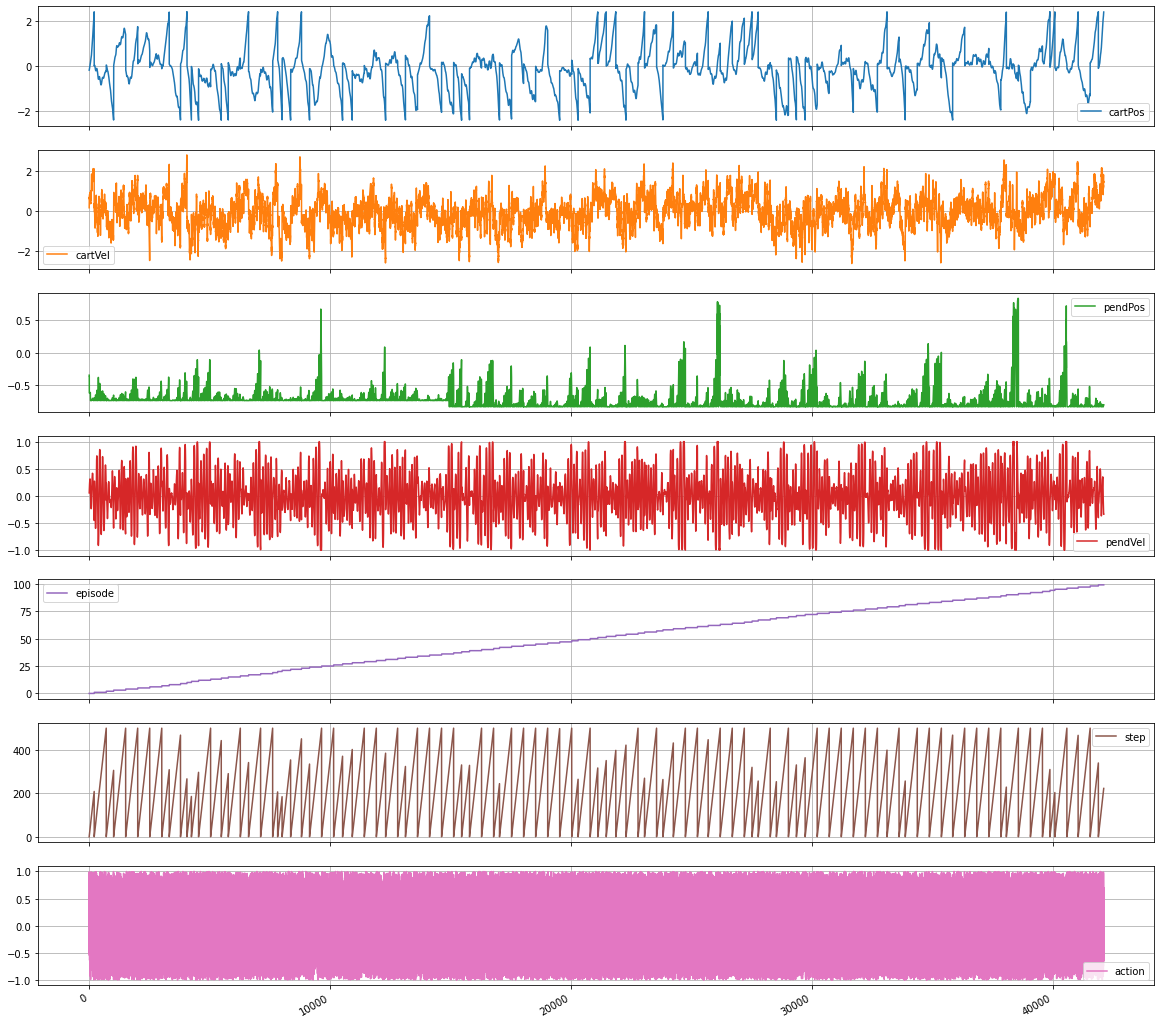

In [220]:
plot = samples.plot(subplots=True, figsize=(20,20), grid=True)
fig = plot[0].get_figure()
fig.savefig(fig_dir + "/sampleplot.png")

In [ ]:
row_max_steps = samples.loc[samples['step'].idxmax()]
print (row_max_steps)

cartPos     -0.246945
cartVel     -0.159944
pendPos     -0.996851
pendVel     -0.079292
episode      1.000000
step       500.000000
action       0.877047
Name: 708, dtype: float64


In [ ]:
samplesEval = samples[samples.episode==row_max_steps.episode]
samplesEval.describe()

,cartPos,cartVel,pendPos,pendVel,episode,step,action
count,500.000000,500.000000,500.000000,500.000000,500.0,500.000000,500.000000
mean,-0.405427,-0.049783,-0.834538,0.018384,1.0,250.500000,0.007306
std,0.231114,0.508288,0.144650,0.531876,0.0,144.481833,0.564505
min,-0.837245,-1.271384,-0.999994,-0.913550,1.0,1.000000,-0.992946
25%,-0.555989,-0.441988,-0.962657,-0.511229,1.0,125.750000,-0.450284
50%,-0.470055,-0.009872,-0.856729,0.080775,1.0,250.500000,0.022366
75%,-0.214289,0.309993,-0.756824,0.520306,1.0,375.250000,0.495721
max,0.030227,1.080842,-0.406725,0.852728,1.0,500.000000,0.997994


Dataset

In [112]:
markov_head = 4
sample_length = len(samples.index)

In [116]:
store = []

dataset = pd.DataFrame()

i = 0

print("Episode: " + str(0))

while (i < sample_length ) :

  new_data = (samples[i:i+1]).to_numpy()[0]

  pendPos = new_data[2]
  pendPosSin = math.sin(pendPos)
  pendPosCos = math.cos(pendPos)

  new_data[2] = pendPosSin
  new_data = np.insert(new_data, 3, pendPosCos)

  store.append(new_data)

  #print(new_data)

  if(len(store) == markov_head + 1):
    if store[0][5] == store[markov_head][5]:
        j = 0
        data = {}
        for j in range(markov_head+1):
          data[CART_POS + str(j+1)] = store[j][0]
          data[CART_VEL + str(j+1)] = store[j][1]
          data[PEND_POS_SIN + str(j+1)] = store[j][2]
          data[PEND_POS_COS + str(j+1)] = store[j][3]
          data[PEND_VEL + str(j+1)] = store[j][4]
          data[ACTION + str(j+1)] = store[j][7]

        #print(data)
        dataset = dataset.append (data, ignore_index=True)
        store.pop(0)
    else:
      clear_output(wait=True)
      print("Episode: " + str(store[markov_head][5]))
      store = [new_data]
  i += 1

print(dataset)

Episode: 99.0
        action1   action2   action3  ...  pendVel3  pendVel4  pendVel5
0      0.841752  0.989132  0.197618  ...  0.061463  0.069940  0.078936
1      0.989132  0.197618 -0.303131  ...  0.069940  0.078936  0.086429
2      0.197618 -0.303131  0.486210  ...  0.078936  0.086429  0.095514
3     -0.303131  0.486210  0.468916  ...  0.086429  0.095514  0.106080
4      0.486210  0.468916  0.866130  ...  0.095514  0.106080  0.119641
...         ...       ...       ...  ...       ...       ...       ...
41719  0.258605 -0.650217  0.629774  ... -0.314432 -0.324729 -0.331790
41720 -0.650217  0.629774  0.007644  ... -0.324729 -0.331790 -0.337720
41721  0.629774  0.007644  0.703092  ... -0.331790 -0.337720 -0.340194
41722  0.007644  0.703092  0.445599  ... -0.337720 -0.340194 -0.340077
41723  0.703092  0.445599 -0.072142  ... -0.340194 -0.340077 -0.339082

[41724 rows x 30 columns]


In [117]:
processed_sample_file = sample_dir + "/" + "processed_sample.csv"

In [118]:
dataset.to_csv(path_or_buf=processed_sample_file, index=False)

In [119]:
dataset = pd.read_csv(processed_sample_file, engine='python', index_col=None)

In [120]:
print(dataset)

        action1   action2   action3  ...  pendVel3  pendVel4  pendVel5
0      0.841752  0.989132  0.197618  ...  0.061463  0.069940  0.078936
1      0.989132  0.197618 -0.303131  ...  0.069940  0.078936  0.086429
2      0.197618 -0.303131  0.486210  ...  0.078936  0.086429  0.095514
3     -0.303131  0.486210  0.468916  ...  0.086429  0.095514  0.106080
4      0.486210  0.468916  0.866130  ...  0.095514  0.106080  0.119641
...         ...       ...       ...  ...       ...       ...       ...
41719  0.258605 -0.650217  0.629774  ... -0.314432 -0.324729 -0.331790
41720 -0.650217  0.629774  0.007644  ... -0.324729 -0.331790 -0.337720
41721  0.629774  0.007644  0.703092  ... -0.331790 -0.337720 -0.340194
41722  0.007644  0.703092  0.445599  ... -0.337720 -0.340194 -0.340077
41723  0.703092  0.445599 -0.072142  ... -0.340194 -0.340077 -0.339082

[41724 rows x 30 columns]


BNN

In [ ]:
# model hyperparamters
modelpath = model_dir + "/" + "model.ckpt"
max_epochs=3
steps_per_epoch = 100
validation_steps = 100
validation_freq = 1

In [125]:
# test data / training data hyperparamters
n_epochs = 10
n_train = int(0.7*samples.shape[0])
n_samples = samples.shape[0]
n_batches = 10
batch_size = np.floor(n_samples/n_batches)
buffer_size = n_samples

In [123]:
inputs = []

j = 0
data = {}
for j in range(markov_head):
  inputs.append(CART_POS + str(j+1))
  inputs.append(CART_VEL + str(j+1))
  inputs.append(PEND_POS_SIN + str(j+1))
  inputs.append(PEND_POS_COS + str(j+1))
  inputs.append(PEND_VEL + str(j+1))
  inputs.append(ACTION + str(j+1))

outputs = [CART_POS + str(markov_head+1), CART_VEL + str(markov_head+1), PEND_POS_SIN + str(markov_head+1), PEND_POS_COS + str(markov_head+1), PEND_VEL + str(markov_head+1)]

print(inputs)
print(outputs)

['cartPos1', 'cartVel1', 'pendPosSin1', 'pendPosCos1', 'pendVel1', 'action1', 'cartPos2', 'cartVel2', 'pendPosSin2', 'pendPosCos2', 'pendVel2', 'action2', 'cartPos3', 'cartVel3', 'pendPosSin3', 'pendPosCos3', 'pendVel3', 'action3', 'cartPos4', 'cartVel4', 'pendPosSin4', 'pendPosCos4', 'pendVel4', 'action4']
['cartPos5', 'cartVel5', 'pendPosSin5', 'pendPosCos5', 'pendVel5']


In [126]:
# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1).repeat(n_epochs)

In [127]:
# Define prior for regularization.
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(outputs), dtype=tf.float64), scale=1.0), reinterpreted_batch_ndims=1)

In [128]:
# Define model instance.
model = tfk.Sequential([
tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
tfp.layers.DenseFlipout(15, activation="relu", name="dense_1"),
tfp.layers.DenseFlipout(tfp.layers.MultivariateNormalTriL.params_size(
len(outputs)), activation=None, name="distribution_weights"),
tfp.layers.MultivariateNormalTriL(len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches), name="output")
], name="model")

# Compile model.
model.compile(optimizer="adam", loss=neg_log_likelihood)

model.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (DenseFlipout)       (None, 15)                735       
_________________________________________________________________
distribution_weights (DenseF (None, 20)                620       
_________________________________________________________________
output (MultivariateNormalTr multiple                  0         
Total params: 1,355
Trainable params: 1,355
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(data_train, epochs=max_epochs, validation_data=data_test,  verbose=True)

Epoch 1/3
70/70 [==============================] - 286s 4s/step - loss: 721.6717 - val_loss: 705.9950
Epoch 2/3
70/70 [==============================] - 288s 4s/step - loss: 700.9540 - val_loss: 685.9922
Epoch 3/3
70/70 [==============================] - 282s 4s/step - loss: 681.0696 - val_loss: 666.3729


In [ ]:
model.save_weights(modelpath.format(epoch=0))

Test Model

In [ ]:
model = tfk.Sequential([
tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
tfp.layers.DenseFlipout(15, activation="relu", name="dense_1"),
tfp.layers.DenseFlipout(tfp.layers.MultivariateNormalTriL.params_size(
len(outputs)), activation=None, name="distribution_weights"),
tfp.layers.MultivariateNormalTriL(len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches), name="output")
], name="model")
model.load_weights(modelpath)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [ ]:
# Predict
samples = 500
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
X_true, Y_true, Y_pred = np.empty(shape=(samples, len(inputs))), np.empty(shape=(samples, len(outputs))), np.empty(shape=(samples, len(outputs), iterations))
for i in range(samples):
    clear_output(wait=True)
    print("Sample: " + str(i+1))
    features, labels = test_iterator.get_next()
    X_true[i,:] = features
    Y_true[i,:] = labels.numpy()
    for k in range(iterations):
        Y_pred[i,:,k] = model.predict(features)
        
# Calculate mean and standard deviation.
Y_pred_m = np.mean(Y_pred, axis=-1)
Y_pred_s = np.std(Y_pred, axis=-1)

Sample: 499


In [ ]:
print(X_true.shape)
print(Y_true.shape)
print(Y_pred_m.shape)

Y_trueT = Y_true.transpose()
X_trueT = X_true.transpose()

Y_pred_mT = Y_pred_m.transpose()

print(X_trueT.shape)
print(Y_trueT.shape)
print(Y_pred_mT.shape)

(500, 5)
(500, 4)
(500, 4)
(5, 500)
(4, 500)
(4, 500)


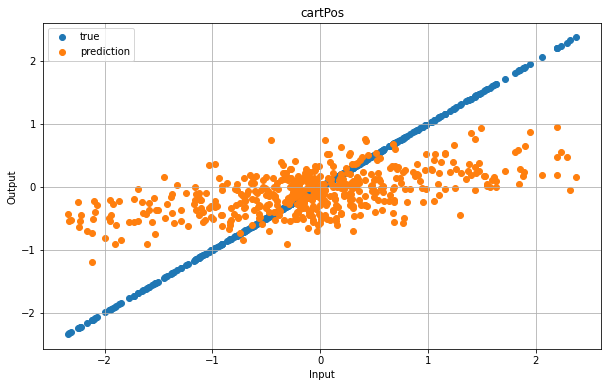

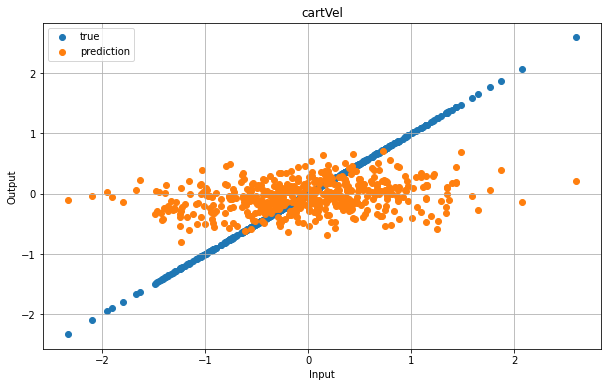

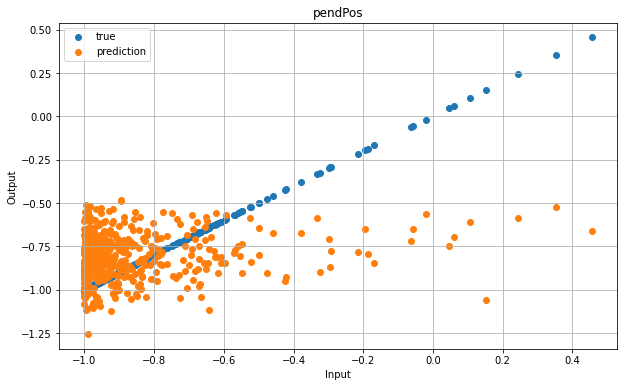

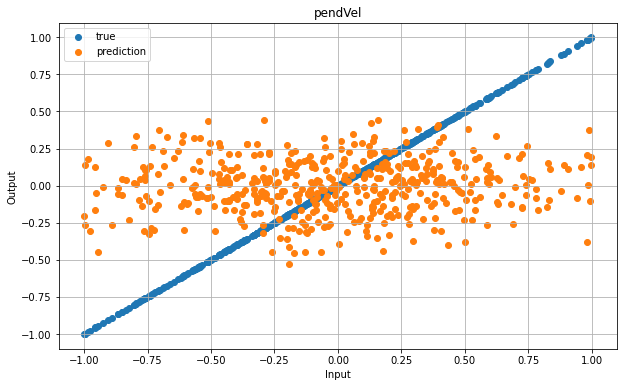

In [ ]:
Y_trueT = Y_true.transpose()
X_trueT = X_true.transpose()
Y_pred_mT = Y_pred_m.transpose()

for i in range(len(outputs)):
  plt.figure(figsize=(10, 6))



  plt.scatter(x=X_trueT[i], y=Y_trueT[i], label="true")
  plt.scatter(x=X_trueT[i], y=Y_pred_mT[i], label="prediction")

  plt.title(label=outputs[i])

  plt.grid()
  plt.legend(loc='best')
  plt.xlabel ("Input")
  plt.ylabel ("Output")

  plt.savefig(fig_dir + "/predictplot" + outputs[i] + ".png")

In [ ]:
import collections

# load model
#model = tf.keras.models.load_model(modelpath, compile=False)
model = tf.keras.models.load_model(model_dir + "/" + "model.h5.bestValLoss", compile=False)

# FIFO-buffer that keeps the neural state
stateBuffer = collections.deque(maxlen=window_size)

# outputs of neural network will be stored here
dfNet = pd.DataFrame(data = d)

for i in range (len(samplesEval)): 
                            
    # estimation of first state
    if i < window_size: 
        state_data = np.float64([samplesEval[CART_POS].values[i], samplesEval[CART_VEL].values[i],
                               samplesEval[PEND_POS].values[i], samplesEval[PEND_VEL].values[i],
                               samplesEval[ACTION].values[i]])
        stateBuffer.append(state_data)
        #print ("Filling initState: %s" % state_data)
    
    # predict successor state
    else: 
        
        # recall of neural network
        state = np.array([list(stateBuffer)])
        if i==5:
            print (state)
        netOutput = model.predict(np.float64(state))[0]
        #print ("Prediction %d: %s" % (i, netOutput))
        
        # append plotting data
        dfNet = dfNet.append ({
            CART_POS:netOutput[0], CART_VEL:netOutput[1],
            PEND_POS:netOutput[2], PEND_VEL:netOutput[3]
        }, ignore_index=True)
        
        # update RNN state
        stateBuffer.append(np.float64([netOutput[0], netOutput[1], 
                                       netOutput[2], netOutput[3], 
                                       dfEval[ACTION].values[i]]))

In [ ]:
fig, axs = plt.subplots (5, 1, figsize=(10,10))

fields = [CART_POS, CART_VEL, PEND_POS, PEND_VEL]

for i in range (len(fields)):
    f = fields[i]
    axs[i].plot(range (len(dfNet)), dfEval[f].values[window_size:], label=f)
    axs[i].plot(range (len(dfNet)), dfNet[f].values, label="prediction", ls="--")
    axs[i].grid()
    axs[i].legend(loc="best")
    
axs[4].plot(range (len(dfNet)), dfEval[ACTION].values[window_size:], label=ACTION)
axs[4].grid()
axs[4].legend(loc="best")

In [ ]:
observation = env.reset()
print('[position,    velocity,   angle,      rotation rate]')
  
while True:
    env.render()
    
    #your agent goes here
    action = env.action_space.sample()

        
    observation, reward, done, info = env.step(action)

    print(f'{observation}   action: {action}')
  
        
    if done: 
      break;
            
env.close()
show_video()

Noised Observation Wrapper with BNN

In [ ]:
uncertainty_malus = -100

In [ ]:
class NoisedObservationWrapper(gym.Wrapper):
    # encapsulate environment with this wrapper and use env just like before:
    # env = NoisedObservationWrapper(gym.make("CartPole-v0"))
    # for PPO2:
    # from stable_baselines.common import make_vec_env
    # env = make_vec_env(NoisedObservationWrapper(gym.make("CartPole-v0")))

    def __init__(self, env, std_dev=0.3, mean=0, angle_min=10, angle_max=20, local_path="false", history):
        super().__init__(env)
        self.env = env
        self.std_dev = std_dev
        self.mean = mean
        self.angle_min = np.radians(angle_min)
        self.angle_max = np.radians(angle_max)
        self.local_path = local_path
        self.history = history
        
        if(self.local_path != "false"):
            log_file = open(self.local_path, "w")
            log_file.close()

    def step(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)




        angle = observation[2]
        
        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        # TODO - non-functional until model
        history.append(observation)
        del(history[0])
        uncertainty = model.predict(history)
        reward = reward + (1-uncertainity)*malus

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()

           
            
        return observation, reward, done, info
    
    def step_noise(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)
        
        angle = observation[2]
        
        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        # TODO - non-functional until model
        history.append(observation)
        del(history[0])
        uncertainty = model.predict(history)
        reward = reward + (1-uncertainity)*malus

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()      
            
        return observation, reward, done, info, noisy

Test Environments

In [131]:
env1Test = gym.make('CartPoleSwingUp-v0')
env1Test = Monitor(env1Test, log_dir1) # required for using callback functions during training
env1Test = DummyVecEnv([lambda: env1Test])
env1Test = VecNormalize(env1Test, norm_obs=True, norm_reward=True) # State normalization

In [132]:
env2Test = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"))
env2Test = Monitor(env2Test, log_dir2) # required for using callback functions during training
env2Test = DummyVecEnv([lambda: env2Test])
env2Test = VecNormalize(env2Test, norm_obs=True, norm_reward=True) # State normalization

Experiment settings

In [129]:
time_steps=30000
num_experiments = 2
sampleCount = 100

Experiments without Uncertainty

In [133]:
tensorboard_dir1 = "cartpole1"
os.makedirs(tensorboard_dir1, exist_ok=True)
for e in range (1, (num_experiments+1), 1):
    env1Test.reset()
    log_dir = (log_dir1+ str(e))
    os.makedirs(log_dir, exist_ok=True)
    env1 = gym.make('CartPoleSwingUp-v0')
    env1 = Monitor(env1, log_dir) # required for using callback functions during training
    env1 = DummyVecEnv([lambda: env1])
    env1 = VecNormalize(env1, norm_obs=True, norm_reward=True) # State normalization
    model1 = PPO(MlpPolicy, env1, verbose=0)
    
    clear_output(wait=True)
    print("Run " +  str(e))
    

    eval_callback = EvalCallback(env1Test, best_model_save_path=log_dir,
                             log_path=log_dir, eval_freq=1000,
                             deterministic=True, render=False)
    
    
    
    model1.learn(total_timesteps=time_steps, callback=eval_callback)

    env1.close()
    
    

Run 2
Eval num_timesteps=1000, episode_reward=-487.49 +/- 16.44
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-489.24 +/- 12.78
Episode length: 500.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-442.40 +/- 29.33
Episode length: 489.80 +/- 20.40
New best mean reward!
Eval num_timesteps=4000, episode_reward=-416.81 +/- 61.04
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5000, episode_reward=-211.47 +/- 24.66
Episode length: 250.60 +/- 46.12
New best mean reward!
Eval num_timesteps=6000, episode_reward=-222.03 +/- 22.36
Episode length: 240.00 +/- 28.06
Eval num_timesteps=7000, episode_reward=-191.75 +/- 25.27
Episode length: 218.20 +/- 41.78
New best mean reward!
Eval num_timesteps=8000, episode_reward=-156.10 +/- 30.13
Episode length: 308.80 +/- 101.41
New best mean reward!
Eval num_timesteps=9000, episode_reward=-113.12 +/- 38.32
Episode length: 259.00 +/- 64.88
New best mean reward!
Eval num_timesteps=1000

Experiment Results without Uncertainty

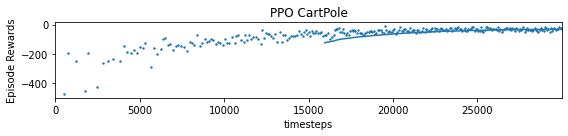

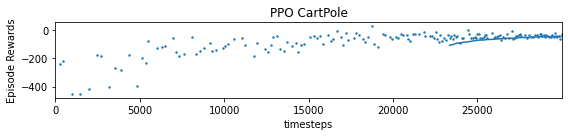

In [236]:
for e in range (1, (num_experiments+1), 1):
    results_plotter.plot_results([log_dir1+str(e)], time_steps, results_plotter.X_TIMESTEPS, "PPO CartPole")

    plt.savefig(fig_dir + "/Results_PPO_" + str(e)  + ".png")
    plt.show()


Best Policy: 2


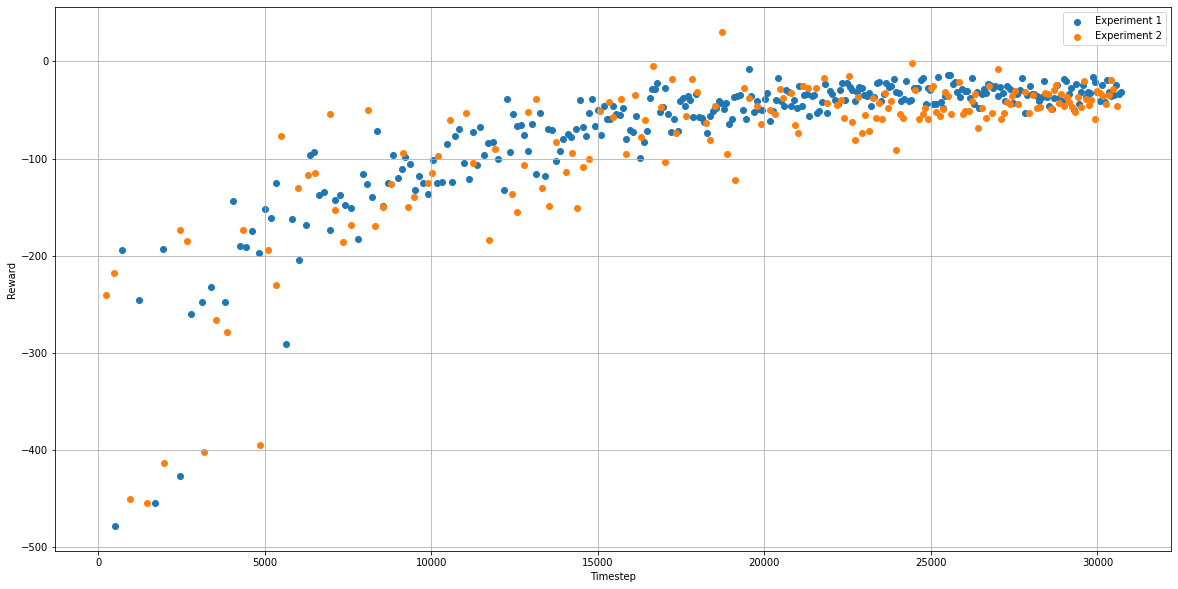

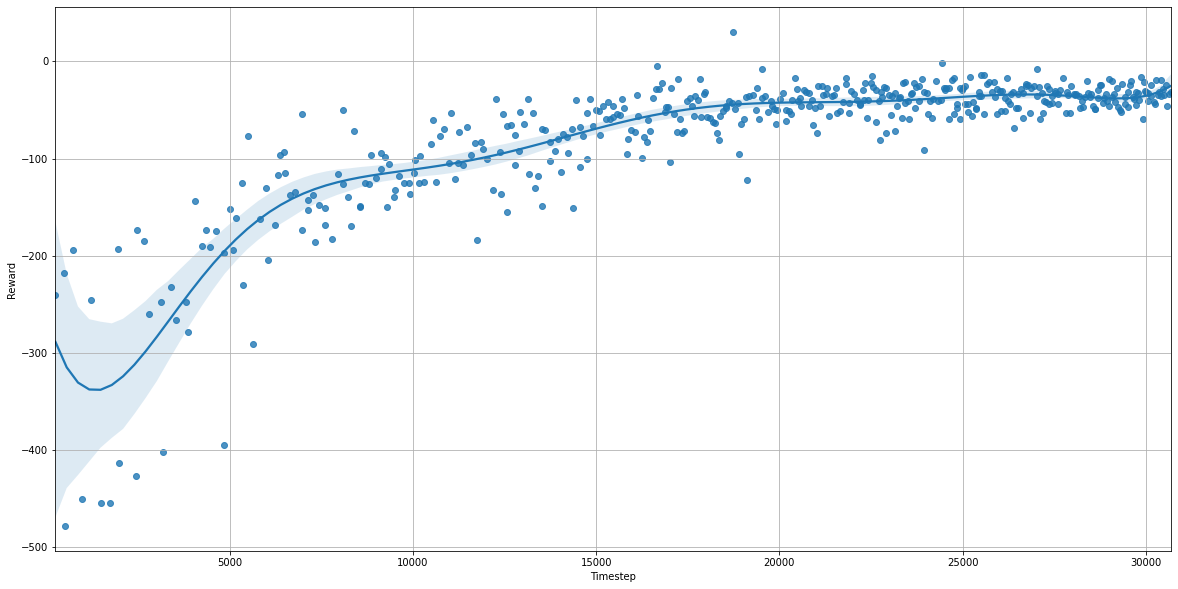

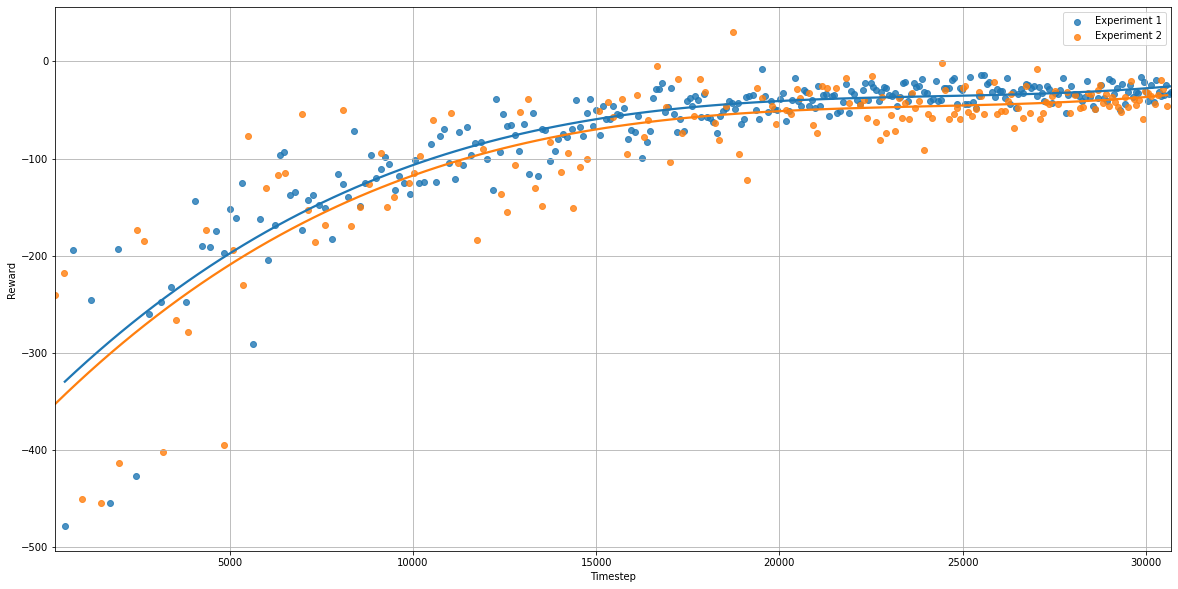

In [238]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

store1 = pd.DataFrame()
exps1 = []

maxreward1 = - math.inf
best1 = 0

for e in range (1, (num_experiments+1), 1):
    log_dir = (log_dir1+ str(e))
    x, y = ts2xy(load_results(log_dir), 'timesteps')
    plt.scatter(x=x, y=y, label="Experiment " + str(e))
    #plt.plot(x, y)
    d = {'x': x, 'y': y}
    exp1 = pd.DataFrame(d)
    exps1.append(exp1)
    store1 = store1.append(exp1, ignore_index=True)
    if (np.max(y) > maxreward1):
      best1 = e

print("Best Policy: " + str(best1))

plt.legend()
plt.ylabel("Reward")
plt.xlabel("Timestep")

#plt.plot(x_mean, y_mean)
#print(store1)

plt.savefig(fig_dir + "/Results_PPO_Points.png")
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
regplot=sb.regplot(x="x", y="y", data=store1, fit_reg=True, scatter=True, order=8,truncate= True)
regplot.grid()
regplot.set_ylabel("Reward")
regplot.set_xlabel("Timestep")

plt.savefig(fig_dir + "/Results_PPO_Combined.png")
plt.show()

fig, regplot2 = plt.subplots(figsize = (20,10))
i = 0
for exp1 in exps1:
    i += 1
    sb.regplot(x="x", y="y", data=exp1, fit_reg=True, scatter=True, order=3,truncate= True, ci=None, label="Experiment " + str(i))
regplot2.grid()
regplot2.legend()
regplot2.set_ylabel("Reward")
regplot2.set_xlabel("Timestep")
plt.savefig(fig_dir + "/Results_PPO_Regression.png")
plt.show()

In [138]:
import pandas as pd
path = googledrive_dir + "logs11/monitor.csv"
data = pd.read_csv(str(path), engine='python', index_col=None, skiprows=1)
#print(data)
data.sum(axis=0)


r   -19614.790597
l    30698.000000
t    14377.496998
dtype: float64

Experiments with Uncertainty

In [139]:
tensorboard_dir2 = "cartpole2"
os.makedirs(tensorboard_dir2, exist_ok=True)
for e in range (1, (num_experiments+1), 1):
    log_dir = (log_dir2 + str(e))
    os.makedirs(log_dir, exist_ok=True)
    env2 = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"))
    env2 = Monitor(env2, log_dir) # required for using callback functions during training
    env2 = DummyVecEnv([lambda: env2])
    env2 = VecNormalize(env2, norm_obs=True, norm_reward=True)

    model2 = PPO(MlpPolicy, env2, verbose=0)

    clear_output(wait=True)
    print("Run " +  str(e))

    eval_callback = EvalCallback(env2Test, best_model_save_path=log_dir,
                             log_path=log_dir, eval_freq=1000,
                             deterministic=True, render=False)

    model2.learn(total_timesteps=time_steps, callback=eval_callback)
    
    env2.close()

Run 2
Eval num_timesteps=1000, episode_reward=-494.30 +/- 4.27
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-486.20 +/- 16.65
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=-311.52 +/- 69.94
Episode length: 318.60 +/- 70.47
New best mean reward!
Eval num_timesteps=4000, episode_reward=-310.11 +/- 89.86
Episode length: 326.40 +/- 103.66
New best mean reward!
Eval num_timesteps=5000, episode_reward=-220.52 +/- 34.81
Episode length: 227.80 +/- 28.39
New best mean reward!
Eval num_timesteps=6000, episode_reward=-232.09 +/- 27.67
Episode length: 312.80 +/- 97.87
Eval num_timesteps=7000, episode_reward=-200.84 +/- 36.75
Episode length: 223.60 +/- 34.14
New best mean reward!
Eval num_timesteps=8000, episode_reward=-198.18 +/- 59.35
Episode length: 216.00 +/- 74.11
New best mean reward!
Eval num_timesteps=9000, episode_reward=-157.19 +/- 40.61
Episode length: 170.60 +/- 37.94
New best mean reward!
E

Experiment Results with Uncertainty 

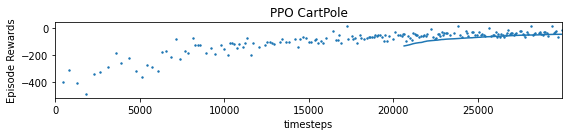

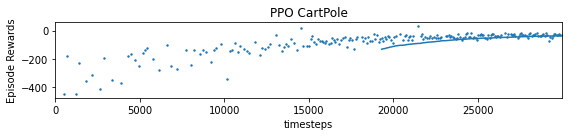

In [239]:
for e in range (1, (num_experiments+1), 1):

    results_plotter.plot_results([log_dir2+str(e)], time_steps, results_plotter.X_TIMESTEPS, "PPO CartPole")
    plt.savefig(fig_dir + "/Results_PPO_Uncertain_" + str(e)  + ".png")
    plt.show()

Best Policy: 2


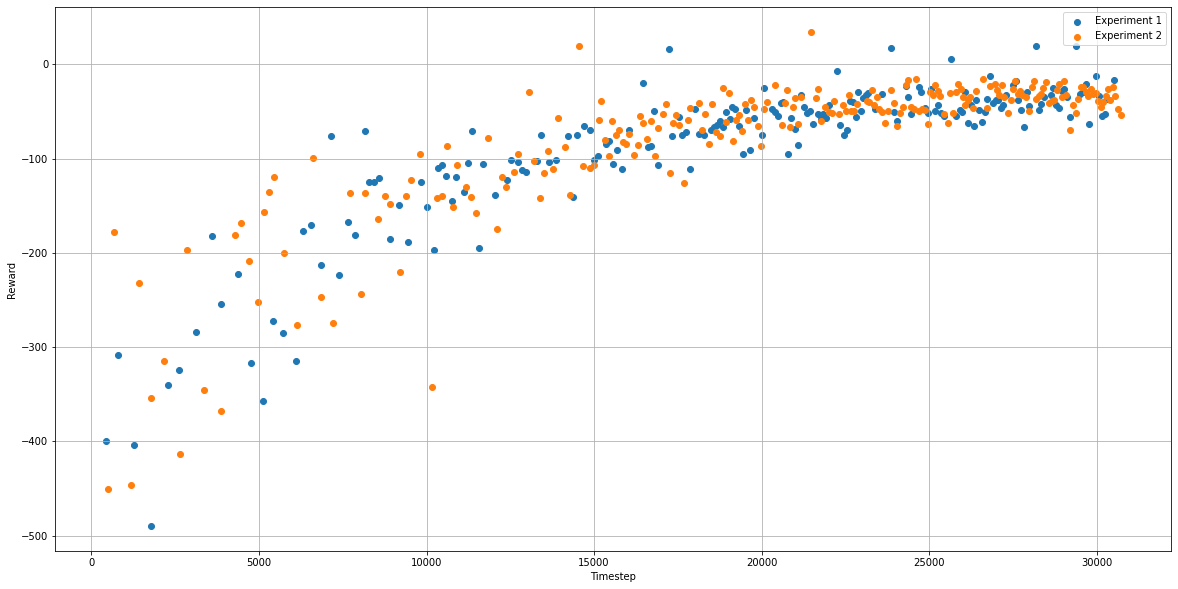

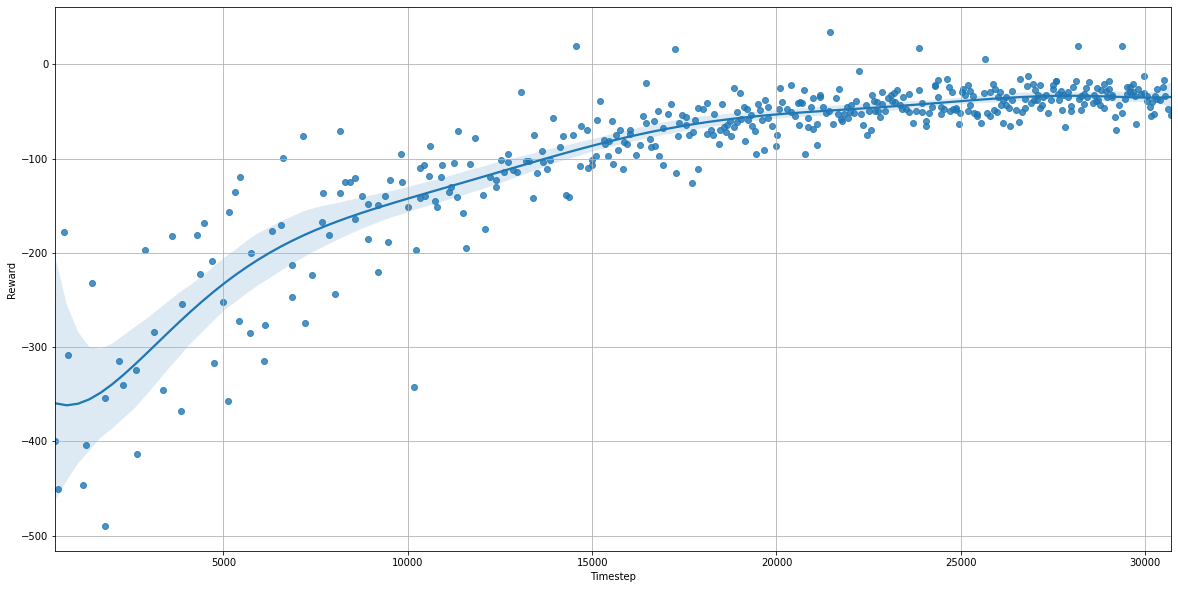

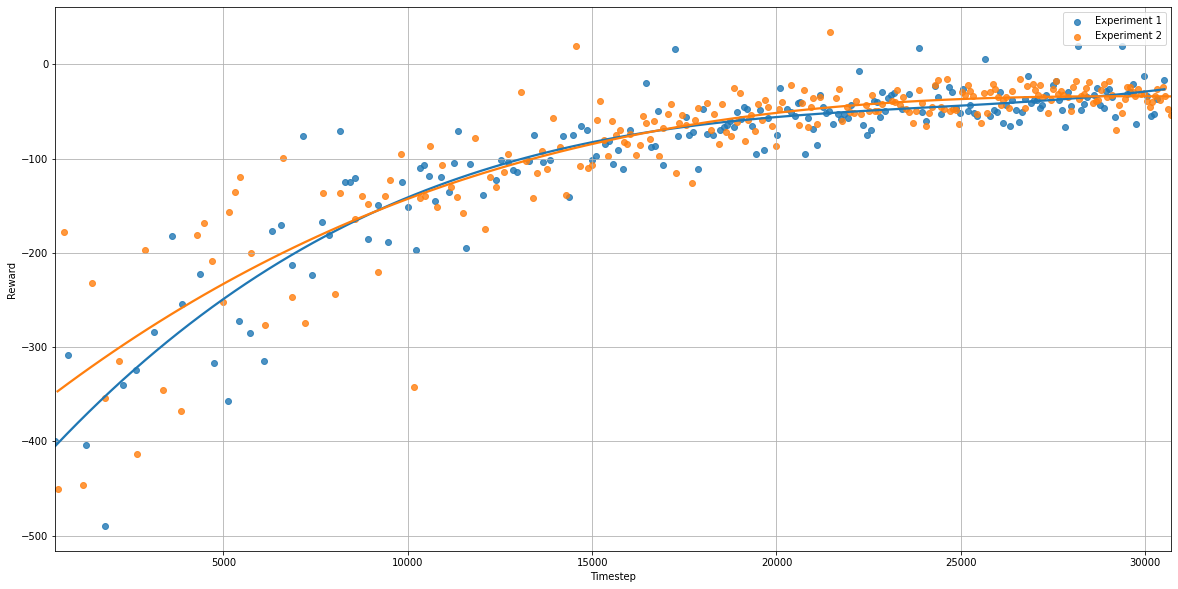

In [240]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

maxreward2 = -math.inf
best2 = 0

store2 = pd.DataFrame()
exps2 = []
for e in range (1, (num_experiments+1), 1):
    log_dir = (log_dir2+ str(e))
    x, y = ts2xy(load_results(log_dir), 'timesteps')
    plt.scatter(x=x, y=y, label = "Experiment " + str(e))
    #plt.plot(x, y)
    d = {'x': x, 'y': y}
    exp2 = pd.DataFrame(d)
    exps2.append(exp2)
    store2 = store2.append(exp2, ignore_index=True)
    if (np.max(y) > maxreward2):
      best2 = e

print("Best Policy: " + str(best2))

plt.legend()
plt.ylabel("Reward")
plt.xlabel("Timestep")
#plt.plot(x_mean, y_mean)
#print(store)
plt.savefig(fig_dir + "/Results_PPO_Uncertain_Points.png")
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
fig.clf()
regplot=sb.regplot(x="x", y="y", data=store2, fit_reg=True, scatter=True, order=8,truncate= True)
regplot.grid()
regplot.set_ylabel("Reward")
regplot.set_xlabel("Timestep")
plt.savefig(fig_dir + "/Results_PPO_Uncertain_Combined.png")
plt.show()

fig, regplot2 = plt.subplots(figsize = (20,10))
i = 0
for exp2 in exps2:
    i += 1
    sb.regplot(x="x", y="y", data=exp2, fit_reg=True, scatter=True, order=3,truncate= True, ci=None, label = "Experiment " + str(i))
regplot2.grid()
regplot2.legend()
regplot2.set_ylabel("Reward")
regplot2.set_xlabel("Timestep")
plt.savefig(fig_dir + "/Results_PPO_Uncertain_Regression.png")
plt.show()



Evaluation of best model



In [151]:
models = []
models.append(PPO.load("%s/best_model.zip" % (log_dir1+str(best1))))
models.append(PPO.load("%s/best_model.zip" % (log_dir1+str(best2))))

index = []
index.append(1)
index.append(2)

In [154]:

env = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"), local_path="test.txt")
env = Monitor(env, log_dir) # required for using callback functions during training

env.training=False

expCounter1 = []

exp = 1

while exp <= sampleCount:
    state = env.reset()
    done=False
    cumReward = 0
    steps=0
    noise = 0
    neg = 0
    pos = 0
    while not done: 
        steps += 1
        action, _states = models[0].predict(state)
        state, reward, done, _, noisy = env.step_noise(action)
        cumReward += reward

        if (action[0]> 0):
            pos += 1
        elif (action[0]< 0):
            neg += 1

        if noisy:
            noise += 1

    env.close()

    if neg > 0:
      negReward = cumReward / neg
      negNoise = noise / neg
    else:
      negReward = 0
      negNoise = 0

    if pos > 0:
      posReward = cumReward / pos
      posNoise = noise / pos
    else:
      posReward = 0
      posNoise = 0
    
    expCounter1.append([steps, cumReward, noise, neg, pos, negReward, posReward, negNoise, posNoise])
    
    clear_output(wait=True)
    print("Experiment " +  str(exp) + " Reward: " + str(cumReward) + " Steps: " + str(neg) + "/" + str(pos) + " Noise: " + str(noise))
    exp+= 1

results1 = np.mat(expCounter1)
#print(results)
clear_output(wait=True)

print ("Average Reward: %.3f" % (np.mean(np.array(results1[:,1]))))
print ("Average Step Count: %.3f" % (np.mean(np.array(results1[:,0]))))
print ("Average Noise: %.3f" % (np.mean(np.array(results1[:,2]))))
print ("Average Noise per Length: %.3f" % (np.mean(np.divide(np.array(results1[:,2]),np.array(results1[:,0])))))
print("Steps: " + str(np.sum(np.array(results1[:,3]))) + "/" + str(np.sum(np.array(results1[:,4]))) )
print("Steps Ratio (Neg): " + str(np.mean(np.divide(np.array(results1[:,3]),np.array(results1[:,0])))))
print("Steps Ratio (Pos): " + str(np.mean(np.divide(np.array(results1[:,4]),np.array(results1[:,0])))))
print("Average Reward per Negative: " + str(np.mean(np.array(results1[:,5]))))
print("Average Reward per Positive: " + str(np.mean(np.array(results1[:,6]))))
print("Average Noise per Negative: " + str(np.mean(np.array(results1[:,7]))))
print("Average Noise per Positive: " + str(np.mean(np.array(results1[:,8]))))

Experiment 100 Reward: 36.43055941257626 Steps: 100/175 Noise: 9


In [159]:
results1df = pd.DataFrame(data=results1, columns=["steps", "reward", "noise" , "neg", "pos", "negReward", "posReward", "negNoise", "posNoise"])
results1df.to_csv(path_or_buf=log_dir + "1/results.csv", index=False)

In [175]:
loaded1 = pd.read_csv(log_dir + "1/results.csv", engine='python', index_col=None)
print(loaded1)

    steps      reward  noise    neg  ...  negReward  posReward  negNoise  posNoise
0   221.0   20.605889    7.0  132.0  ...   0.156105   0.231527  0.053030  0.078652
1   314.0  150.008993    2.0  176.0  ...   0.852324   1.087022  0.011364  0.014493
2   361.0  125.624452    8.0  142.0  ...   0.884679   0.573628  0.056338  0.036530
3   270.0   83.637951    6.0   97.0  ...   0.862247   0.483456  0.061856  0.034682
4   394.0  147.961624   10.0  148.0  ...   0.999741   0.601470  0.067568  0.040650
..    ...         ...    ...    ...  ...        ...        ...       ...       ...
95  309.0   65.100311   12.0  119.0  ...   0.547061   0.342633  0.100840  0.063158
96  209.0  -16.002392    9.0  144.0  ...  -0.111128  -0.246191  0.062500  0.138462
97  251.0   82.027954    2.0  149.0  ...   0.550523   0.804196  0.013423  0.019608
98  230.0  -10.931597    7.0   85.0  ...  -0.128607  -0.075390  0.082353  0.048276
99  275.0   36.430559    9.0  100.0  ...   0.364306   0.208175  0.090000  0.051429

[10

In [183]:
env = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"), local_path="test.txt")
env = Monitor(env, log_dir) # required for using callback functions during training

env.training=False

expCounter2 = []

exp = 1
while exp <= sampleCount:
    state = env.reset()
    done=False
    cumReward = 0
    steps=0
    noise = 0
    neg = 0
    pos = 0

    while not done: 
        steps += 1
        action, _states = models[1].predict(state)
        state, reward, done, _, noisy = env.step_noise(action)
        cumReward += reward
        
        if (action[0]> 0):
            pos += 1
        elif (action[0]< 0):
            neg += 1

        if noisy:
            noise += 1

    env.close()
    
    if neg > 0:
      negReward = cumReward / neg
      negNoise = noise / neg
    else:
      negReward = 0
      negNoise = 0

    if pos > 0:
      posReward = cumReward / pos
      posNoise = noise / pos
    else:
      posReward = 0
      posNoise = 0
    
    expCounter2.append([steps, cumReward, noise, neg, pos, negReward, posReward, negNoise, posNoise])
    
    clear_output(wait=True)
    print("Experiment " +  str(exp) + " Reward: " + str(cumReward) + " Steps: " + str(neg) + "/" + str(pos) + " Noise: " + str(noise))
    exp+= 1

results2 = np.mat(expCounter2)
#print(results)


clear_output(wait=True)

print ("Average Reward: %.3f" % (np.mean(np.array(results2[:,1]))))
print ("Average Step Count: %.3f" % (np.mean(np.array(results2[:,0]))))
print ("Average Noise: %.3f" % (np.mean(np.array(results2[:,2]))))
print ("Average Noise per Length: %.3f" % (np.mean(np.divide(np.array(results2[:,2]),np.array(results2[:,0])))))
print("Steps: " + str(np.sum(np.array(results2[:,3]))) + "/" + str(np.sum(np.array(results2[:,4]))) )
print("Steps Ratio (Neg): " + str(np.mean(np.divide(np.array(results2[:,3]),np.array(results2[:,0])))))
print("Steps Ratio (Pos): " + str(np.mean(np.divide(np.array(results2[:,4]),np.array(results2[:,0])))))
print("Average Reward per Negative: " + str(np.mean(np.array(results2[:,5]))))
print("Average Reward per Positive: " + str(np.mean(np.array(results2[:,6]))))
print("Average Noise per Negative: " + str(np.mean(np.array(results2[:,7]))))
print("Average Noise per Positive: " + str(np.mean(np.array(results2[:,8]))))

Average Reward: 38.195
Average Step Count: 235.770
Average Noise: 6.740
Average Noise per Length: 0.027
Steps: 10462.0/13115.0
Steps Ratio (Neg): 0.4750444078041084
Steps Ratio (Pos): 0.5249555921958917
Average Reward per Negative: 0.16491877796129079
Average Reward per Positive: -0.040485593895230855
Average Noise per Negative: 0.06802006796386027
Average Noise per Positive: 0.04938832795827849


In [184]:
results2df = pd.DataFrame(data=results2, columns=["steps", "reward", "noise" , "neg", "pos", "negReward", "posReward", "negNoise", "posNoise"])
results2df.to_csv(path_or_buf=log_dir + "2/results.csv", index=False)

Graph Content


In [185]:
variants = ["PPO (Base, no noise)", "PPO (Base, noise)"]

In [192]:
stepCounter = []
rewardCounter = []
noiseCounter = []
negCounter = []
posCounter = []
avgNoiseCounter = []
negRewardCounter = []
posRewardCounter = []
negNoiseCounter = []
posNoiseCounter = []
stepRatio = []

for i in range(len(variants)) :
  loaded = pd.read_csv(log_dir + str(i+1) + "/results.csv", engine='python', index_col=None)
  stepCounter.append(np.array(loaded["steps"]))
  rewardCounter.append(np.array(loaded["reward"]))
  noiseCounter.append(np.array(loaded["noise"]))
  negCounter.append(np.array(loaded["neg"]))
  posCounter.append(np.array(loaded["pos"]))
  avgNoiseCounter.append(np.divide(np.array(loaded["noise"]),np.array(loaded["steps"])))
  negRewardCounter.append(np.array(loaded["negReward"]))
  posRewardCounter.append(np.array(loaded["posReward"]))
  negNoiseCounter.append(np.array(loaded["negNoise"]))
  posNoiseCounter.append(np.array(loaded["posNoise"]))
  stepRatio.append(np.divide(np.array(loaded["neg"]),np.array(loaded["steps"])))

Experiment Length

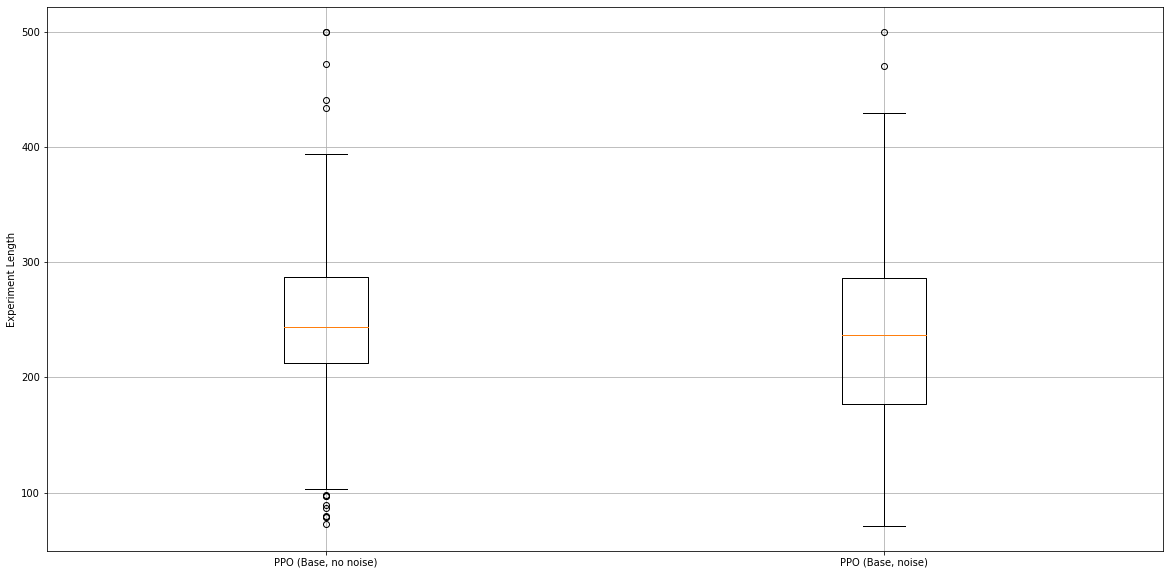

In [244]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

boxplot_data  = {}
for i in range(len(variants)):
 boxplot_data[variants[i]] = np.reshape(stepCounter[i],newshape=-1)

plt.boxplot(boxplot_data.values(), labels = boxplot_data.keys())

plt.ylabel("Experiment Length")
plt.savefig(fig_dir + "/ExperimentLength.png")
plt.show()

Noise per Experiment Length

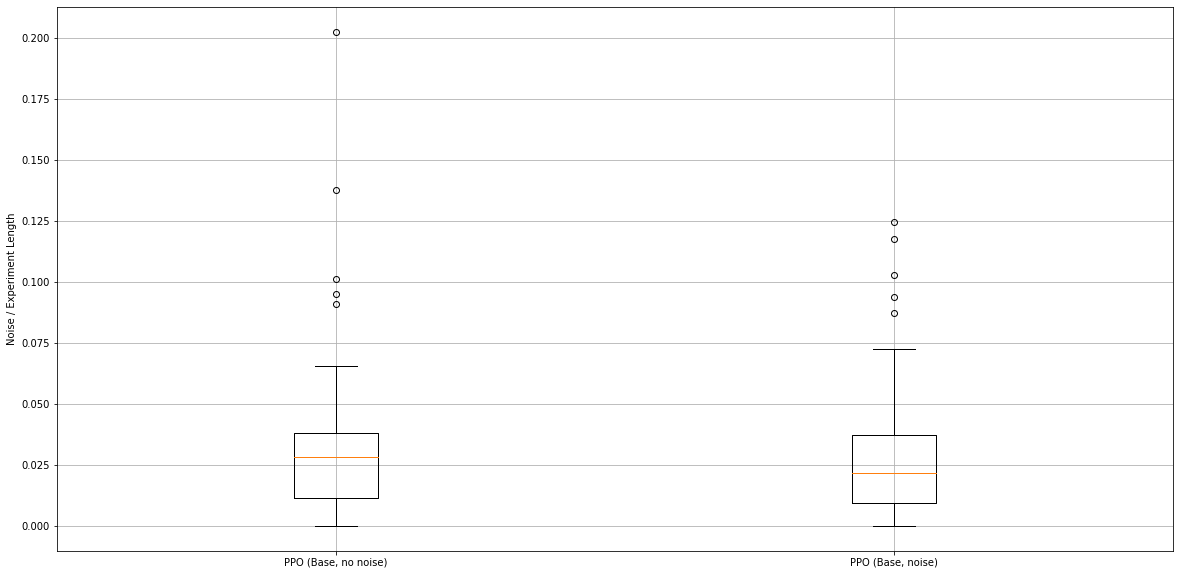

In [243]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

boxplot_data  = {}
for i in range(len(variants)):
 boxplot_data[variants[i]] = np.reshape(np.divide(noiseCounter[i],stepCounter[i]),newshape=-1)

plt.boxplot(boxplot_data.values(), labels = boxplot_data.keys())

plt.ylabel("Noise / Experiment Length")
plt.savefig(fig_dir + "/Noise+ExperimentLength.png")
plt.show()

Noise per Length

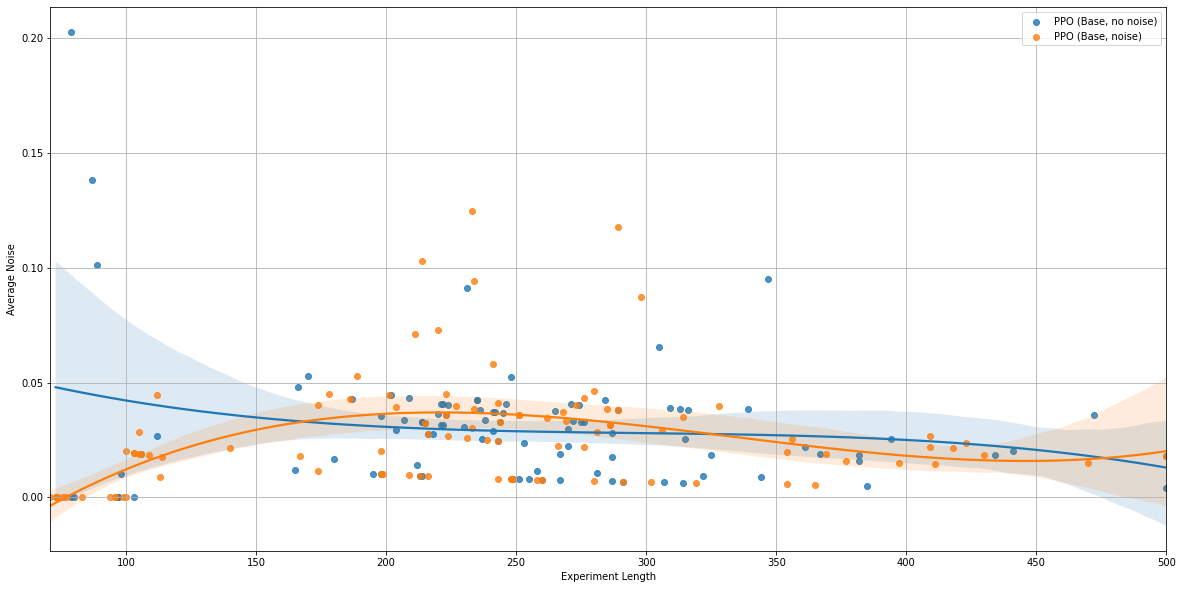

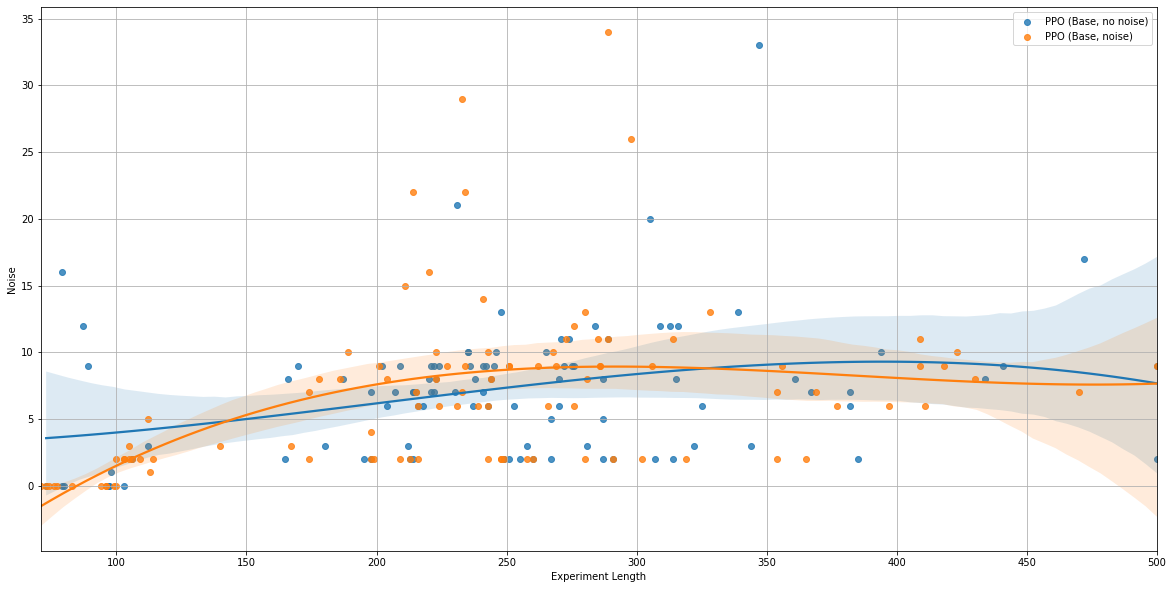

In [245]:
fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepCounter[i],-1), y=np.reshape(avgNoiseCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.legend()
regplot.set_ylabel("Average Noise")
regplot.set_xlabel("Experiment Length")
regplot.grid()
plt.savefig(fig_dir + "/AvNoiseLength.png")
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepCounter[i],-1), y=np.reshape(noiseCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Noise")
regplot.set_xlabel("Experiment Length")
regplot.legend()
regplot.grid()
plt.savefig(fig_dir + "/NoiseLength.png")
plt.show()

Noise per Reward

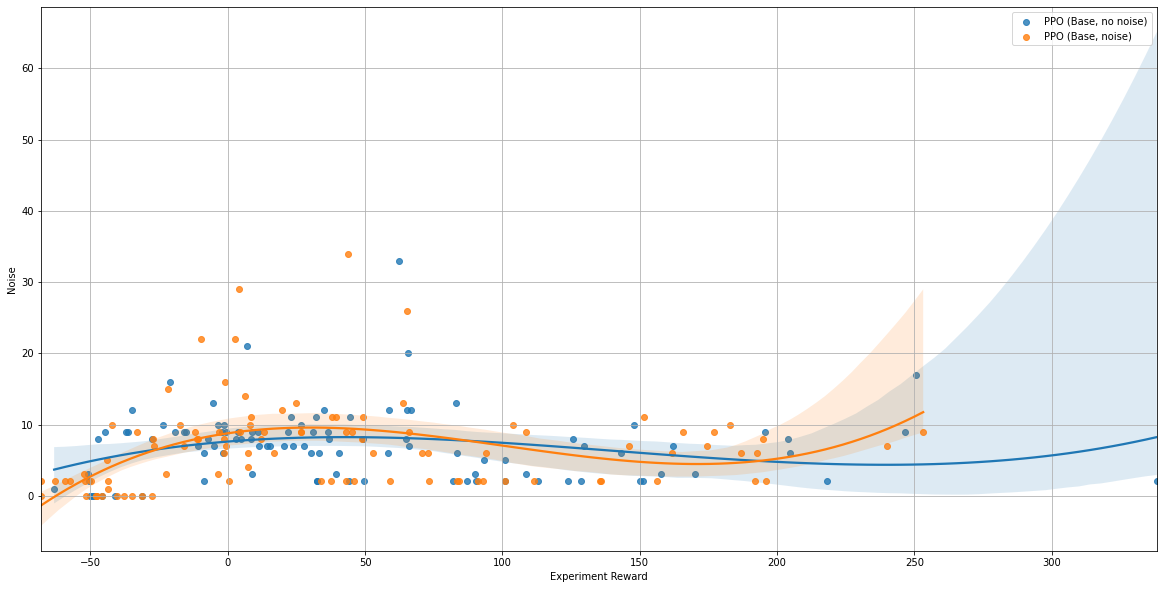

In [246]:
fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(rewardCounter[i],-1), y=np.reshape(noiseCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Noise")
regplot.set_xlabel("Experiment Reward")
regplot.legend()
regplot.grid()
plt.savefig(fig_dir + "/NoiseReward.png")
plt.show()

Reward per Experiment Length

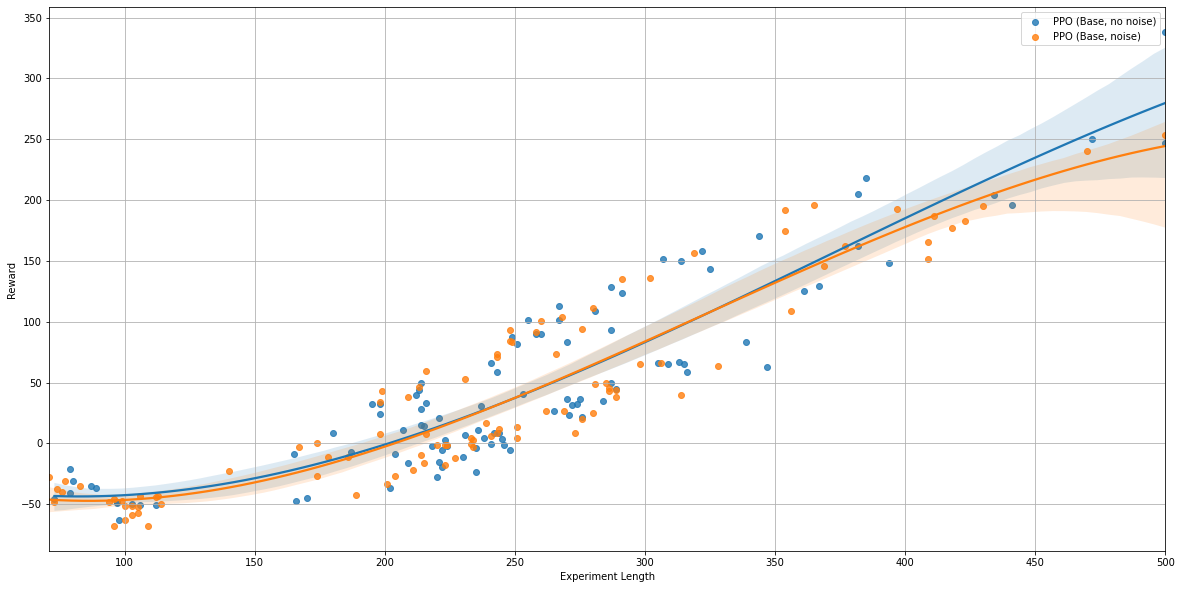

In [247]:
fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepCounter[i],-1), y=np.reshape(rewardCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Reward")
regplot.set_xlabel("Experiment Length")
regplot.legend()
regplot.grid()
plt.savefig(fig_dir + "/RewardLength.png")
plt.show()

Direction

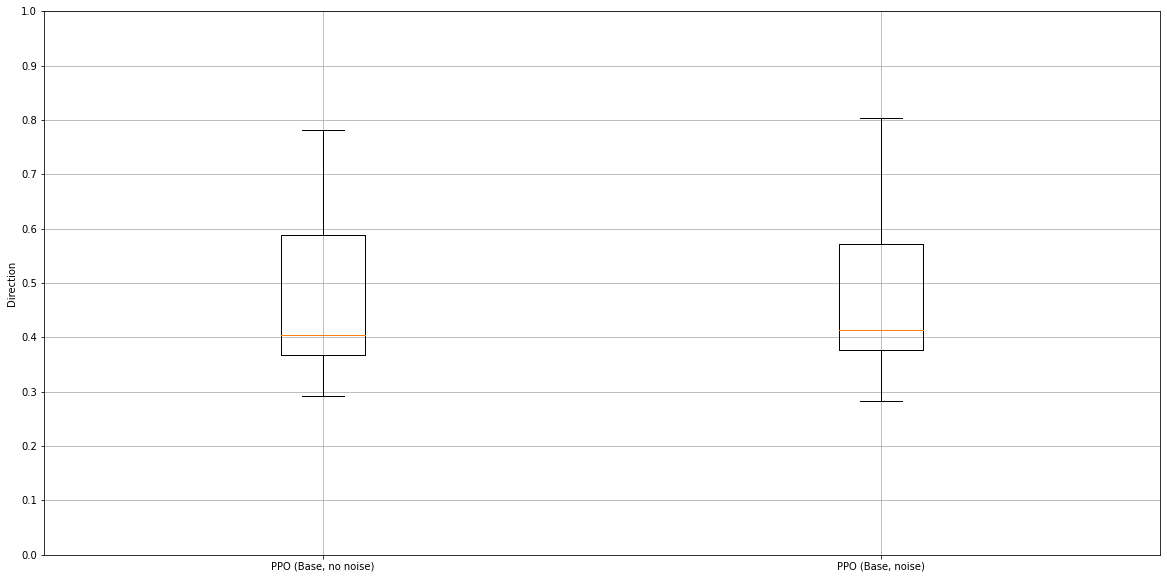

In [248]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()


boxplot_data  = {}
for i in range(len(variants)):
 boxplot_data[variants[i]] = np.reshape(stepRatio[i],newshape=-1)

plt.boxplot(boxplot_data.values(), labels = boxplot_data.keys())

plt.ylabel("Direction")

plt.ylim(0,1)
plt.yticks(np.arange(0, 1.01, step=0.1)) 
plt.savefig(fig_dir + "/ExperimentDirection.png")
plt.show()

Experiment Length per Direction

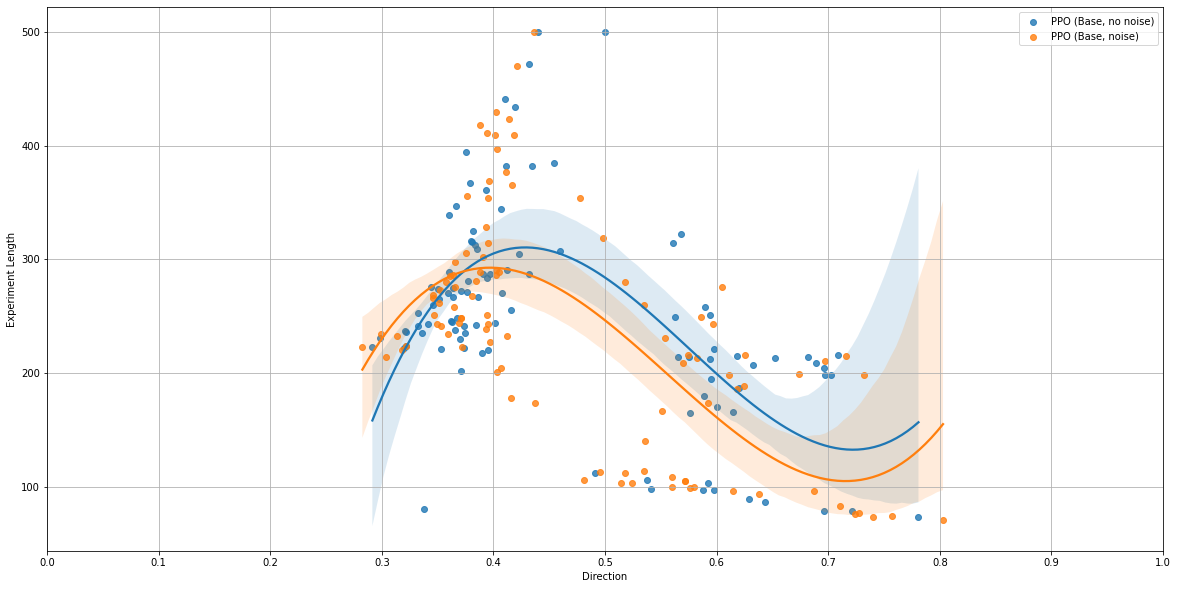

In [249]:
fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepRatio[i],-1), y=np.reshape(stepCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Experiment Length")
regplot.set_xlabel("Direction")
regplot.legend()
regplot.grid()
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.01, step=0.1)) 
plt.savefig(fig_dir + "/DirectionLength.png")
plt.show()

Reward per Direction

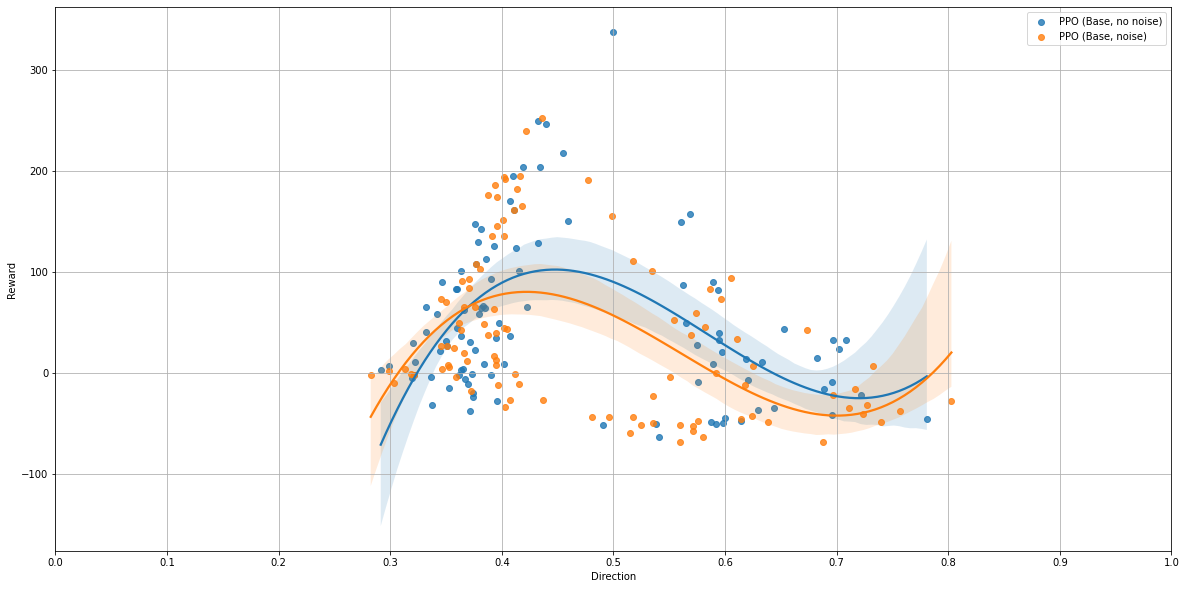

In [250]:
fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepRatio[i],-1), y=np.reshape(rewardCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Reward")
regplot.set_xlabel("Direction")
regplot.legend()
regplot.grid()
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.01, step=0.1)) 
plt.savefig(fig_dir + "/RewardDirection.png")
plt.show()

Noise per Direction

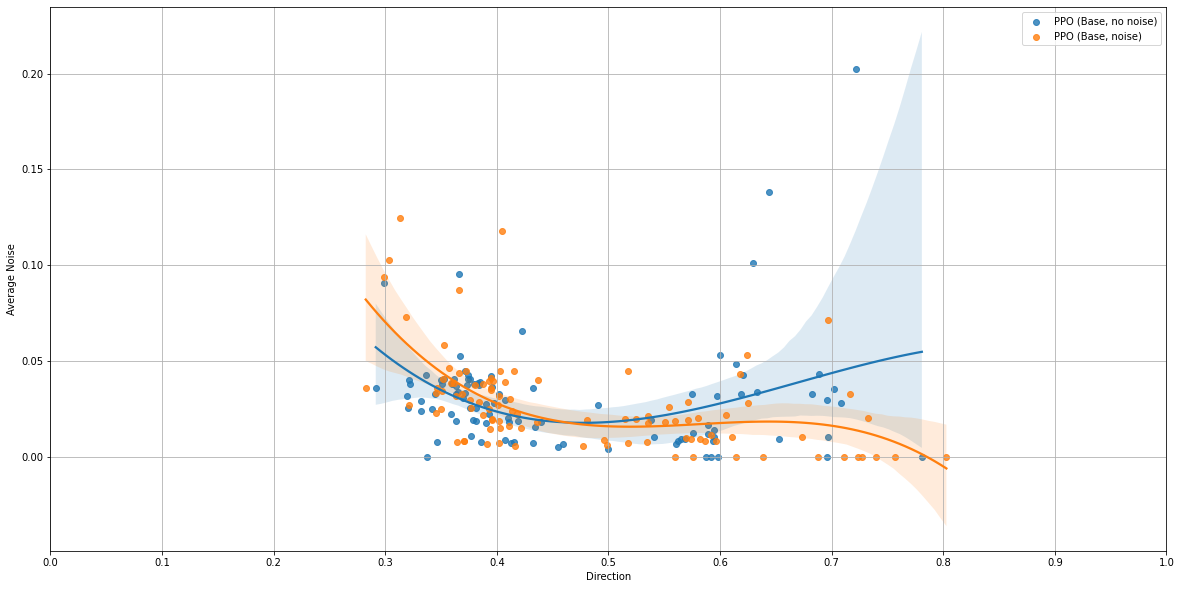

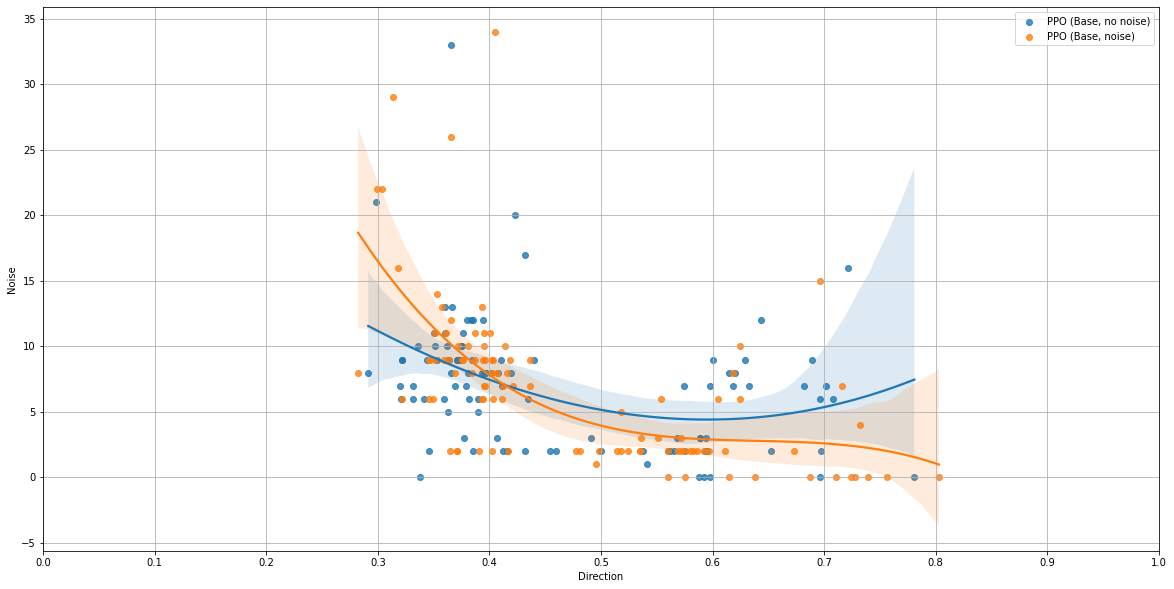

In [251]:
fig, regplot = plt.subplots(figsize = (20,10))


for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepRatio[i],-1), y=np.reshape(avgNoiseCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.legend()
regplot.set_ylabel("Average Noise")
regplot.set_xlabel("Direction")
regplot.grid()
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.01, step=0.1)) 
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))

for i in range(len(variants)):
 sb.regplot(x=np.reshape(stepRatio[i],-1), y=np.reshape(noiseCounter[i],-1), fit_reg=True, scatter=True, order=3,truncate= True, label=variants[i])

regplot.set_ylabel("Noise")
regplot.set_xlabel("Direction")
regplot.legend()
regplot.grid()
plt.xlim(0,1)
plt.xticks(np.arange(0, 1.01, step=0.1)) 
plt.savefig(fig_dir + "/NoiseDirection.png")
plt.show()